# Analysis of COVID-19 expression across disease conditions

Application of `SiFT` on COVID-19 immune landscape depicted  single-cell transcriptome, surface proteome and T and B lymphocyte antigen receptor analyses of over 780,000 peripheral blood mononuclear cells from a cross-sectional cohort of 130 patients with varying severities of COVID-19 collected by Stephenson et al. (2021) [[1]](https://doi.org/10.1038/s41591-021-01329-2).


[[1] Stephenson, E., Reynolds, G., Botting, R. A., Calero-Nieto, F. J., Morgan, M. D., Tuong, Z. K., ... & Haniffa, M. (2021). Single-cell multi-omics analysis of the immune response in COVID-19. Nature medicine, 27(5), 904-916.](https://doi.org/10.1038/s41591-021-01329-2)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import scanpy as sc
import scvelo as scv
import tarfile
import functools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import gseapy
import scib

from scipy.spatial import distance
from scipy.stats import linregress
from scipy.stats import mannwhitneyu

import re
import sift

In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Helper functions

In [4]:
def cluster_purity(x):
    """
    calculate cluster purity.
    - assign it with the most frequent class label
    - define purity as (# label / # total)
    """
    unique_, counts_ = np.unique(x, return_counts=True)
    return np.max(counts_) / len(x)
    
def mannwhitneyu_test(adata, score_key="IFN_score"):
    """
    one-tail test
    """
    result = []
    for _celltype in adata.obs["cell_type"].cat.categories:
        exp_group = adata[adata.obs["cell_type"] == _celltype].obs[score_key]
        ctrl_group = adata[adata.obs["cell_type"] != _celltype].obs[score_key]
        
        _, _pval1 = mannwhitneyu(exp_group, 
                                 ctrl_group,
                                alternative="greater")
        result.append([_celltype, _pval1])
    PVAL_df = pd.DataFrame(result, columns=['cell_type', 'pvalue'])
    
    return PVAL_df

In [5]:
# pre-processing adapted from the analysis done in the original publication
def process_adata(
    adata, 
    n_neighbors=10, 
    use_rep = "X_pca",
    n_pcs=30, 
    hvg=True,
    n_top_genes = 2000,
    scale=True,
    graph=False,
    resolution=1,
):
    for key_ in ["X_pca_harmony", "X_pca", "X_umap"]:
        if key_ in adata.obsm:
            del adata.obsm[key_] 
    for key_ in ["leiden", "neighbors", "pca", "umap"]:
        if key_ in adata.uns:
            del adata.uns[key_]
    
    adata.raw = adata  
    if hvg:
        print("hvg")
        if "hvg" in adata.uns:
            del adata.uns["hvg"]
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=3000,
            subset=True,
            layer="counts",
            flavor="seurat_v3",
        )
    if scale:    
        print("scale")
        sc.pp.scale(adata, max_value=10)
    
    print("pca")
    sc.tl.pca(adata, svd_solver="arpack")
    
    if use_rep == "X_pca_harmony":
        print("pca_harmony")
        sc.external.pp.harmony_integrate(adata, "sample_id", basis="X_pca", adjusted_basis="X_pca_harmony")
        
    print("nns")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep=use_rep, n_pcs=n_pcs)
    
    print("umap")
    sc.tl.umap(adata)

    print("leiden")
    sc.tl.leiden(adata, resolution = resolution)
    
    if graph: 
        print("graph")
        sc.tl.draw_graph(adata, layout='fa')

## Set Parameters


In [6]:
DATA_DIR =  str(DATA_DIR) + "/healthdisease_covid19/"
FIG_DIR = str(FIG_DIR) + "/healthdisease_covid19/"

In [71]:
import seaborn as sns
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 2, 
                            "legend.frameon":"True"})

In [8]:
#https://www.gsea-msigdb.org/gsea/msigdb/cards/GOBP_RESPONSE_TO_TYPE_I_INTERFERON
IFN_genes = ["ABCE1","ADAR","BST2","CACTIN","CDC37","CNOT7","DCST1","EGR1","FADD","GBP2","HLA-A","HLA-B","HLA-C","HLA-E","HLA-F","HLA-G","HLA-H","HSP90AB1","IFI27","IFI35","IFI6","IFIT1","IFIT2","IFIT3","IFITM1","IFITM2","IFITM3","IFNA1","IFNA10","IFNA13","IFNA14","IFNA16","IFNA17","IFNA2","IFNA21","IFNA4","IFNA5","IFNA6","IFNA7","IFNA8","IFNAR1","IFNAR2","IFNB1","IKBKE","IP6K2","IRAK1","IRF1","IRF2","IRF3","IRF4","IRF5","IRF6","IRF7","IRF8","IRF9","ISG15","ISG20","JAK1","LSM14A","MAVS","METTL3","MIR21","MMP12","MUL1","MX1","MX2","MYD88","NLRC5","OAS1","OAS2","OAS3","OASL","PSMB8","PTPN1","PTPN11","PTPN2","PTPN6","RNASEL","RSAD2","SAMHD1","SETD2","SHFL","SHMT2","SP100","STAT1","STAT2","TBK1","TREX1","TRIM56","TRIM6","TTLL12","TYK2","UBE2K","USP18","WNT5A","XAF1","YTHDF2","YTHDF3","ZBP1"]

## Load original data

In [ ]:
adata = sc.read(DATA_DIR +"haniffa21.processed.h5ad")

In [ ]:
adata.layers["counts"] = adata.layers["raw"].copy()
adata.X = adata.layers["raw"].copy()
del adata.layers["raw"]

In [ ]:
adata_protein = adata[:, adata.var["feature_types"] == "Antibody Capture"].copy()
adata_rna = adata[:, adata.var["feature_types"] == "Gene Expression"].copy()

In [ ]:
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)

In [ ]:
sc.pp.highly_variable_genes(
    adata_rna,
    n_top_genes=3000,
    subset=False,
    layer="counts",
    flavor="seurat_v3",
)

In [ ]:
keep = adata_rna.var["highly_variable"] | adata_rna.var_names.isin(IFN_genes) 

In [ ]:
adata_rna = adata_rna[:, keep]

In [ ]:
adata = adata_rna.copy()
adata.obsm["protein"] = adata_protein.X.copy()
adata.uns["proteins"] = adata_protein.var_names.values.copy()

In [ ]:
control = "Healthy"
adata.obs["control"] = False
adata.obs.loc[adata.obs["Status_on_day_collection_summary"].isin([control]), "control"]  = True
adata.obs["disease"] = False
adata.obs.loc[adata.obs["Status_on_day_collection_summary"].isin(["Asymptomatic", 
                                                              "Critical",
                                                              "Mild",
                                                              "Moderate",
                                                              "Severe"]), "disease"]  = True

In [ ]:
adata.write(DATA_DIR +"haniffa21.hvg.h5ad")

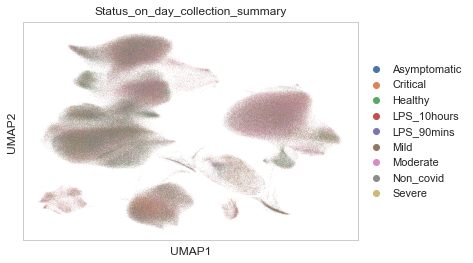

In [11]:
sc.pl.umap(adata, 
           color=["Status_on_day_collection_summary"])

## Load processed data

In [ ]:
adata = sc.read(DATA_DIR +"haniffa21.hvg.h5ad")

## Create reference `adata` results

In [ ]:
adata_refh = adata[adata.obs["Status_on_day_collection_summary"].isin([
    "Asymptomatic", 
    "Critical",
    "Mild",
    "Moderate",
    "Severe", 
    "Healthy"]), :].copy()

In [ ]:
adata_ref = adata[adata.obs["Status_on_day_collection_summary"].isin([
    "Asymptomatic", 
    "Critical",
    "Mild",
    "Moderate",
    "Severe"
]), :].copy()

In [ ]:
adata_refh.write(DATA_DIR + "covid19.refh.h5ad")

In [ ]:
adata_ref.write(DATA_DIR + "covid19.ref.h5ad")

## Plot abstract figure

In [12]:
Tcell_colors = [
    "#1B9E77","#D95F02", "#7570B3","#E7298A",
    "#66A61E","#E6AB02","#A6761D","#666666",
    "#A6CEE3","#1F78B4","#B2DF8A","#33A02C",
    "#FB9A99","#E31A1C", "#FDBF6F","#FF7F00",
    "#CAB2D6","#FFFF99","#B15928"
]

Tcells = [
    "CD4.Naive", "CD4.CM", "CD4.EM", "CD4.IL22", 
    "CD4.Prolif", "CD4.Th1", "CD4.Th2", "CD4.Th17", 
    "CD4.Tfh", "Treg", "CD8.Naive", "CD8.Activated", 
    "CD8.Prolif", "CD8.CM", "CD8.TE", "CD8.EM",
    "gdT", "MAIT", "NKT"
]

Tcells = ["gdT", "CD4.IL22", "CD8.EM", "MAIT"]
Tcell_colors = ["#A6761D", "#E6AB02", "#66A61E", "#B2DF8A"]

In [13]:
adata_tcells = adata[adata.obs["full_clustering"].isin(Tcells).values].copy()

In [14]:
adata_tcells.obs["full_clustering"].value_counts()

CD8.EM      18917
CD4.IL22    18379
gdT         15942
MAIT        10992
Name: full_clustering, dtype: int64

In [15]:
sc.pp.subsample(adata_tcells, 0.05)

In [16]:
process_adata(adata_tcells)
adata_tcells.uns["full_clustering_colors"] = Tcell_colors

hvg
scale
pca
nns
umap
leiden


In [17]:
sc.tl.leiden(adata_tcells, 0.5)

In [18]:
adata_tcells.uns["leiden_colors"] = [
    "#B15928",
    "#FB9A99", "#FDBF6F","#FF7F00",
    "#CAB2D6","#A6CEE3","#1B9E77",
]

In [19]:
disease_cells = np.random.choice(adata_tcells.obs_names, 20)

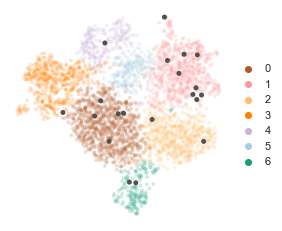

In [20]:
fig, axs = plt.subplots(1, figsize=(4,4))
sc.pl.umap(
    adata_tcells, 
    color=["leiden"],
    frameon=False,
    show=False,
    size=60,
    alpha=0.2,
    ax=axs
)

sc.pl.umap(
    adata_tcells[disease_cells], 
    frameon=False,
    show=False,
    size=100,
    ax=axs,
    na_color='#525252',
)
plt.title("")
# plt.savefig(FIG_DIR + f"mock_healthy_disease.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [21]:
adata_tcells_disease = adata_tcells[disease_cells].copy()

In [22]:
adata_tcells_disease = adata_tcells_disease[adata_tcells_disease.obsm["X_umap"][:, 0].argsort()]

In [23]:
adata_tcells_disease.obsm["X_umap_flatten"] = adata_tcells_disease.obsm["X_umap"].copy()
adata_tcells_disease.obsm["X_umap_flatten"][:, 1] = 0
adata_tcells_disease.obsm["X_umap_flatten"][:, 0] = np.arange(adata_tcells_disease.n_obs)

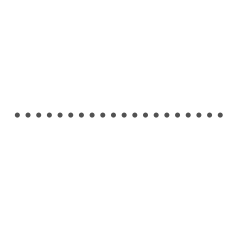

In [24]:
fig, axs = plt.subplots(1, figsize=(4,4))
sc.pl.embedding(
    adata_tcells_disease,
    basis="X_umap_flatten",
    frameon=False,
    show=False,
    size=100,
    ax=axs,
    na_color='#525252',
)
plt.title("")
# plt.savefig(FIG_DIR + f"mock_disease_orig.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

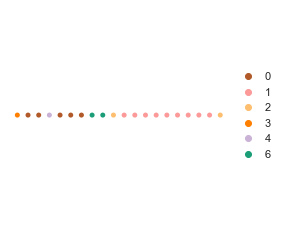

In [25]:
fig, axs = plt.subplots(1, figsize=(4,4))
sc.pl.embedding(
    adata_tcells_disease,
    basis="X_umap_flatten",
    color=["leiden"],
    frameon=False,
    show=False,
    size=100,
    ax=axs,
    # na_color='#8c0800',
)
plt.title("")
# plt.savefig(FIG_DIR + f"mock_disease_map.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Apply `SiFT`

In [ ]:
adata = adata[adata.obs["Status_on_day_collection_summary"].isin([
    "Asymptomatic", 
    "Critical",
    "Mild",
    "Moderate",
    "Severe", 
    "Healthy"]), :].copy()

adata = adata[adata.obs["Status_on_day_collection_summary"].argsort(), :]

In [26]:
metric = "knn"

Filter the healthy signal

In [ ]:
adata_sift = sift.sifter(
    adata=adata,
    kernel_key="X_pca_harmony",
    metric=metric,
    n_neighbors=15,
    embedding_key="X",
    src_key = "disease",
    tgt_key = "control",
    use_tgt=True,
    pseudocount=False,
    copy=True
)
    

## Save results

keep only the clinical samples

In [ ]:
adata_sift = adata_sift[adata_sift.obs["Status_on_day_collection_summary"].isin([
    "Asymptomatic", 
    "Critical",
    "Mild",
    "Moderate",
    "Severe",]), :].copy()

In [ ]:
process_adata(
    adata_sift, 
    n_neighbors=10, 
    use_rep = "X_pca_harmony",
    n_pcs=40, 
    hvg=False,
    scale=False,
    graph=False,
)

In [ ]:
adata_sift.write(DATA_DIR + f"covid19.sift.{metric}.h5ad")

## Analyze `SiFT`ed vs `Original` data

In [30]:
adatas_paths = {"SiFT (PCA, healthy)":  f"covid19.sift.knn.h5ad", 
                "Original": f"covid19.ref.h5ad", 
                "Original (w\\ healthy)": f"covid19.refh.h5ad"
               }

In [31]:
adatas =  {} 
for key_, path_ in adatas_paths.items():
    adatas[key_] = sc.read(DATA_DIR + path_) 

Only considering the two last: ['.tgt', '.h5ad'].
Only considering the two last: ['.tgt', '.h5ad'].


In [32]:
cell_types = ["CD4", 
              "Treg", 
              "CD8",  
              "gdT",
              "MAIT",
              "NK_16hi", 
              "NK_56hi",
              "B_cell", 
              "Plasmablast",
              "CD14", 
              "CD16", 
              "DCs", 
              "pDC",  
              "HSC", 
              "Platelets", 
              "RBC",
              "Lymph_prolif",
              "Mono_prolif"
             ]

cell_colors = ["#A9DCE0","#E794EA", "#A9E0AB", "#CE5B5B", "#EDA6A6", "#E2E8A6", "#3A5CA0", "#D68645", "#48B758",
               "#B4AEE5", "#F9BD95", "#67a5e5", "#d8e1a7", "#C683ED", "#F7B5CD", "#E53320", "#6FC6CE", "#1B78AC"]

In [33]:
cell_types_names = { 
    "CD4": r"$\rm{CD}4^{+}\rm{\ T\ cell}$", 
    "Treg": r"$\rm{T}_{reg}$", 
    "CD8": r"$\rm{CD}8^{+}\rm{\ T\ cell}$",  
    "gdT": r"$\gamma \delta \rm{\ T\ cell}$",
    "MAIT": r"$\rm{MAIT}$",
    "NK_16hi": r"$\rm{NK\ CD}56^{low}$", 
    "NK_56hi": r"$\rm{NK\ CD}56^{high}$",
    "B_cell":  r"$\rm{B\ cell}$", 
    "Plasmablast":  r"$\rm{Plasmablast}$",
    "CD14":  r"$\rm{CD}14^{+}\rm{\ mono.}$", 
    "CD16": r"$\rm{CD}16^{+}\rm{\ mono.}$", 
    "DCs":  r"$\rm{cDC}$",
    "pDC":  r"$\rm{pDC}$",  
    "HSC":  r"$\rm{HSPC}$", 
    "Platelets":  r"$\rm{Platelet}$", 
    "RBC":  r"$\rm{RBC}$",
    "Lymph_prolif":  r"$\rm{Prolif.\ lymph.}$",
    "Mono_prolif":  r"$\rm{Prolif.\ mono.}$",
}


In [34]:
for key in adatas:
    if key == "Original (w\\ healthy)":
        adatas[key].obs["Status_on_day_collection_summary"] = adatas[key].obs["Status_on_day_collection_summary"].cat.reorder_categories(["Healthy", "Asymptomatic",  "Mild", "Moderate", "Severe", "Critical",])
        adatas[key].uns["Status_on_day_collection_summary_colors"] = ["#00805a", "#fed976", "#fd8d3c", "#e31a1c", "#800026", "#252525"]
    else:
        adatas[key].obs["Status_on_day_collection_summary"] = adatas[key].obs["Status_on_day_collection_summary"].cat.reorder_categories(["Asymptomatic",  "Mild", "Moderate", "Severe", "Critical",])
        adatas[key].uns["Status_on_day_collection_summary_colors"] = ["#fed976", "#fd8d3c", "#e31a1c", "#800026", "#252525"]
    adatas[key].obs["initial_clustering"] = adatas[key].obs["initial_clustering"].cat.reorder_categories(cell_types)
    adatas[key].uns["initial_clustering_colors"] = cell_colors
    adatas[key].obs["cell_type"] = adatas[key].obs["initial_clustering"].copy()
    adatas[key].obs["cell_type"] = adatas[key].obs["cell_type"].cat.rename_categories(cell_types_names)
    adatas[key].uns["cell_type_colors"] = cell_colors
        
    

In [35]:
adatas["SiFT (PCA, healthy)"].uns["leiden_colors"] = ["#FED439", "#9DACAB", "#7996C6", "#8D9296", "#BEA687", "#E39668", "#F97E4E",
                                                      "#DECA8D", "#7FB5AF", "#3679AD", "#C86253", "#9B6734", "#4D8352", "#6BC3D9",
                                                      "#51608C", "#2C1439", "#0B4947", "#792529", "#B91316", "#93311E", "#457368",
                                                      "#6294A1", "#FD8CC1"]

In [36]:
for key in adatas:
    sc.tl.score_genes(adatas[key], gene_list=IFN_genes, score_name="IFN_score", use_raw=False)

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [37]:
pval_dict = {}
ind_dict = {}
for key, adata_ in adatas.items():
    pval_dict[key] = mannwhitneyu_test(adata_, score_key="IFN_score")
    ind_dict[key] = pval_dict[key][pval_dict[key]["pvalue"] < 0.05]["cell_type"]

In [38]:
ind_dict

{'SiFT (PCA, healthy)': 9     $\rm{CD}14^{+}\rm{\ mono.}$
 10    $\rm{CD}16^{+}\rm{\ mono.}$
 11                     $\rm{cDC}$
 12                     $\rm{pDC}$
 13                    $\rm{HSPC}$
 17          $\rm{Prolif.\ mono.}$
 Name: cell_type, dtype: object,
 'Original': 2       $\rm{CD}8^{+}\rm{\ T\ cell}$
 3     $\gamma \delta \rm{\ T\ cell}$
 5              $\rm{NK\ CD}56^{low}$
 6             $\rm{NK\ CD}56^{high}$
 10       $\rm{CD}16^{+}\rm{\ mono.}$
 11                        $\rm{cDC}$
 12                        $\rm{pDC}$
 16            $\rm{Prolif.\ lymph.}$
 Name: cell_type, dtype: object,
 'Original (w\\ healthy)': 2       $\rm{CD}8^{+}\rm{\ T\ cell}$
 3     $\gamma \delta \rm{\ T\ cell}$
 5              $\rm{NK\ CD}56^{low}$
 6             $\rm{NK\ CD}56^{high}$
 10       $\rm{CD}16^{+}\rm{\ mono.}$
 12                        $\rm{pDC}$
 16            $\rm{Prolif.\ lymph.}$
 17             $\rm{Prolif.\ mono.}$
 Name: cell_type, dtype: object}

## Analyze results

### Plot `UMAP`s

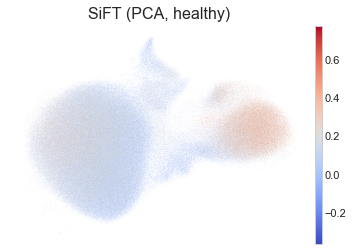

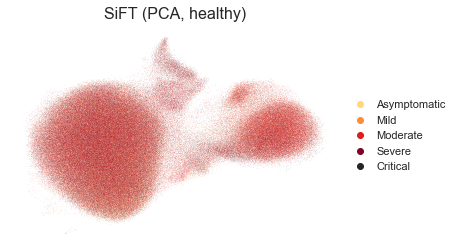

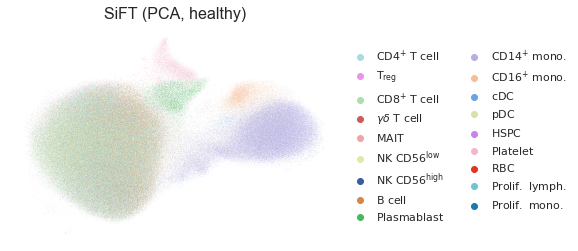

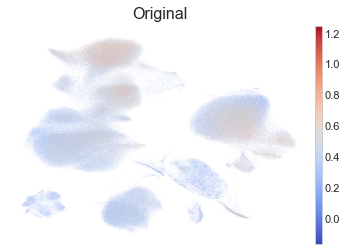

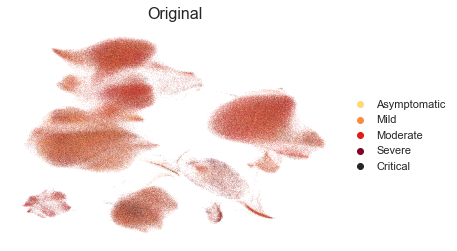

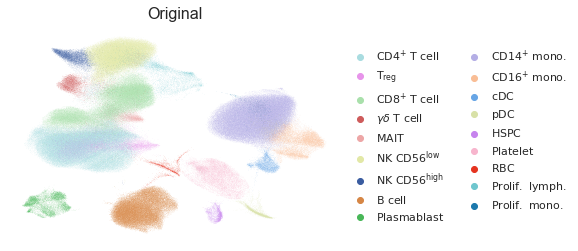

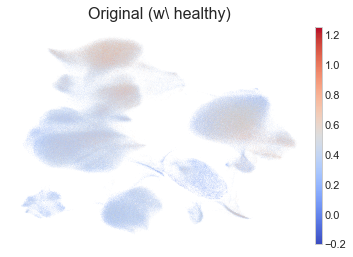

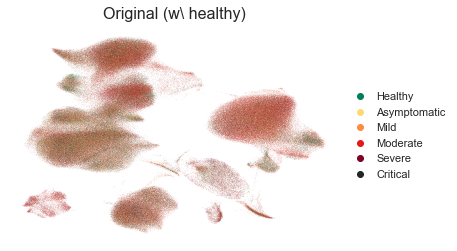

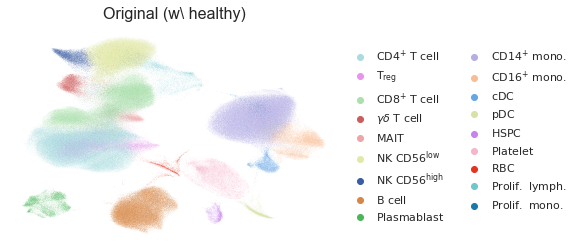

In [39]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
for key in adatas:
    for color in ["IFN_score", "Status_on_day_collection_summary", "cell_type"]:
        sc.pl.umap(adatas[key], 
                   color=color, 
                   cmap=cmap, 
                   frameon=False, 
                   show=False)
        
        plt.title(key, fontsize=16)
        # plt.savefig(FIG_DIR + f"{key}_{color}_umap.png", dpi=300, bbox_inches="tight", transparent=True)
        plt.show()

### Assess scores 

In [40]:
df_scores = sc.get.obs_df(adatas["SiFT (PCA, healthy)"], ["IFN_score",
                                                          "cell_type", 
                                                          "Status_on_day_collection_summary",
                                                         ]) 

df_scores = df_scores.rename(columns={"IFN_score":"IFN response (SiFT, control)"})


In [41]:
df_scores_orig = sc.get.obs_df(adatas["Original"], ["IFN_score",
                                                    "cell_type", 
                                                    "Status_on_day_collection_summary",])

df_scores_orig = df_scores_orig.rename(columns={"IFN_score":"IFN response (Original)"})


In [42]:

df_scores_origh = sc.get.obs_df(adatas["Original (w\\ healthy)"], ["IFN_score", 
                                                                   "cell_type", 
                                                                   "Status_on_day_collection_summary",])

df_scores_origh = df_scores_origh.rename(columns={"IFN_score":"IFN response (Original, w\\ healthy)"})


In [43]:
dfs = {"SiFT (PCA, healthy)": df_scores, 
       "Original": df_scores_orig, 
       "Original (w\\ healthy)": df_scores_origh}

In [44]:
dfs_grouped = {}
for key, df_ in dfs.items():
    dfs_grouped[key] = df_.groupby(["Status_on_day_collection_summary",  "cell_type",]).mean()
    

In [45]:
dfs_full = {}
for key, dfs_grouped_ in dfs_grouped.items():
    dfs_ = {}
    columns = adatas[key].obs["cell_type"].cat.categories
    index = adatas[key].obs["Status_on_day_collection_summary"].cat.categories
    scores = dfs_grouped_.columns
    for score in scores:
        dfs_[score] = pd.DataFrame(columns=columns, index=index, dtype="float")
        for ind in dfs_grouped_.index:
            dfs_[score].loc[ind[0], ind[1]] =  float(dfs_grouped_.loc[ind, score])
        if "Healthy" in dfs_[score].index:
            dfs_[score] = dfs_[score].reindex(["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical",])
        else:
            dfs_[score] = dfs_[score].reindex(["Asymptomatic", "Mild", "Moderate", "Severe", "Critical",])
    dfs_full[key] = dfs_

In [46]:
dfs_full['SiFT (PCA, healthy)'].keys()

dict_keys(['IFN response (SiFT, control)'])

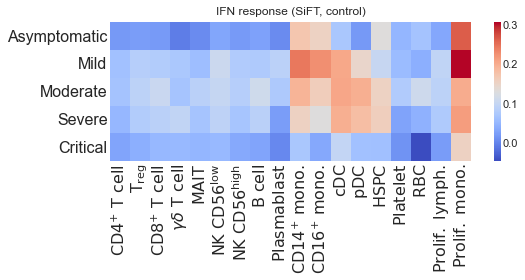

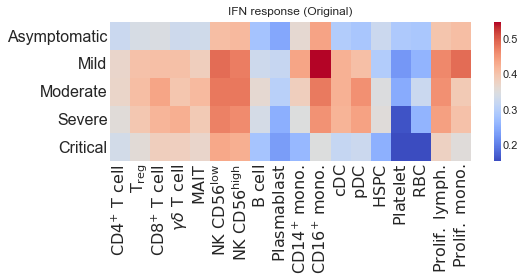

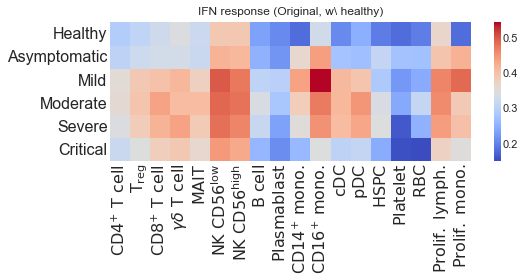

In [47]:
## Plot IFN response individual
rows = 1
cols = 1
size = 4
cmap = sns.color_palette("coolwarm", as_cmap=True)

for ki, keyi in enumerate(dfs_full):
    dfs_c = dfs_full[keyi]
    for kj, keyj in enumerate(dfs_full[keyi]):
        if "IFN response" in keyj:
            fig, axs = plt.subplots(rows, cols, figsize=(cols*(size*2), rows*size))
            sns.heatmap(dfs_c[keyj], ax=axs, cmap=cmap,)
            axs.set_title(keyj)
            axs.set_xticklabels(axs.get_xticklabels(), fontsize=16)
            axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)
            plt.tight_layout()
            # plt.savefig(FIG_DIR + f"{keyj}.png", dpi=300, bbox_inches="tight", transparent=True)
            plt.show()


## Cluster analysis

In [48]:
sns.color_palette("dark").as_hex()

['#001c7f',
 '#b1400d',
 '#12711c',
 '#8c0800',
 '#591e71',
 '#592f0d',
 '#a23582',
 '#3c3c3c',
 '#b8850a',
 '#006374']

In [49]:
dark_colors = list(sns.color_palette("dark").as_hex())

In [50]:
informative_cluster_colors = [dark_colors[3], dark_colors[0], dark_colors[2]]

In [51]:
informative_cluster_colors

['#8c0800', '#001c7f', '#12711c']

In [52]:
adatas["Original"].obs["leiden_sift"] = adatas["SiFT (PCA, healthy)"].obs["leiden"].copy()
adatas["Original"].uns["leiden_sift_colors"]  = adatas["SiFT (PCA, healthy)"].uns["leiden_colors"]

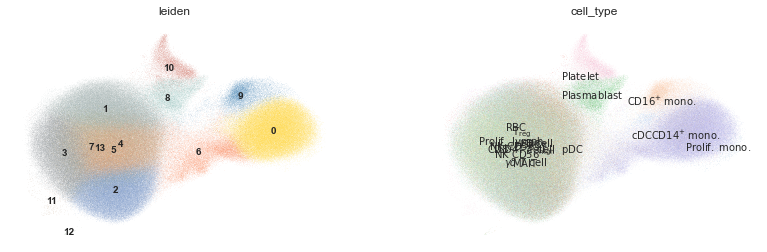

In [53]:
sc.pl.umap(adatas["SiFT (PCA, healthy)"], 
           color=["leiden","cell_type",], frameon=False, legend_loc = "on data")

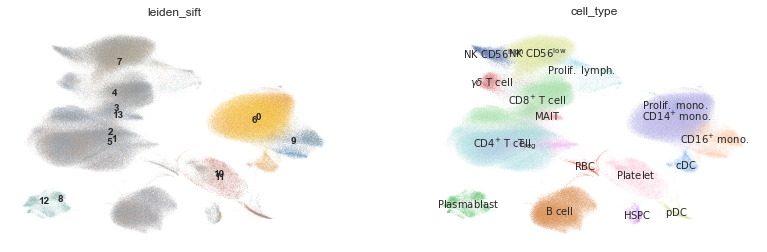

In [54]:
sc.pl.umap(adatas["Original"], 
           color=["leiden_sift","cell_type",],frameon=False, legend_loc = "on data")

In [55]:
threshold = 0.55
min_clust_size = 20
clusters_purity = {}
cluster_size = {}
informative_clusters = []
for cluster in adatas["SiFT (PCA, healthy)"].obs["leiden"].cat.categories:
    clusters_purity[cluster] = cluster_purity(adatas["SiFT (PCA, healthy)"][adatas["SiFT (PCA, healthy)"].obs["leiden"].isin([cluster])].obs["cell_type"])
    cluster_size[cluster] = adatas["SiFT (PCA, healthy)"][adatas["SiFT (PCA, healthy)"].obs["leiden"].isin([cluster])].shape[0]
    if clusters_purity[cluster] > threshold and cluster_size[cluster] > min_clust_size:
        informative_clusters.append(cluster)

In [56]:
adatas["SiFT (PCA, healthy)"].obs["informative_cluster"] = "disease non-informative"
adatas["SiFT (PCA, healthy)"].obs.loc[adatas["SiFT (PCA, healthy)"].obs["leiden"].isin(informative_clusters), "informative_cluster"]  = "disease informative"
adatas["SiFT (PCA, healthy)"].obs["informative_cluster"] = adatas["SiFT (PCA, healthy)"].obs["informative_cluster"].astype("category")
adatas["SiFT (PCA, healthy)"].uns["informative_cluster_colors"]  = informative_cluster_colors


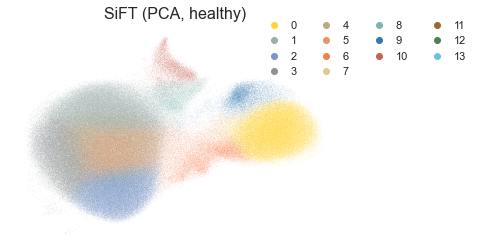

In [57]:
sc.pl.umap(
    adatas["SiFT (PCA, healthy)"], 
    color="leiden",
    frameon=False, 
    show=False
)
plt.legend(ncol=4, loc="center right", bbox_to_anchor=(1.4, 0.9),)
        
plt.title("SiFT (PCA, healthy)", fontsize=16)
# plt.savefig(FIG_DIR + f"SiFT_leiden_umap.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

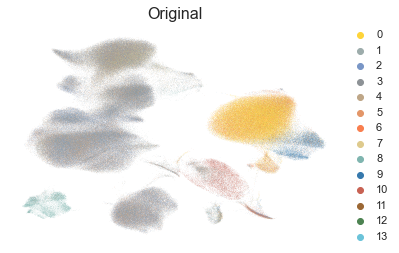

In [58]:

sc.pl.umap(
    adatas["Original"], 
    color="leiden_sift",
    frameon=False, 
    show=False
)
        
plt.title("Original", fontsize=16)
# plt.savefig(FIG_DIR + f"Original_leiden_sift_umap.png", dpi=300, bbox_inches="tight", transparent=True)
        plt.show()

In [59]:
adatas["Original"].obs["informative_cluster"] = adatas["SiFT (PCA, healthy)"].obs["informative_cluster"].copy()
adatas["Original"].uns["informative_cluster_colors"]  = informative_cluster_colors

In [60]:
adatas["Original (w\\ healthy)"].obs["informative_cluster"] = "healthy"
adatas["Original (w\\ healthy)"].obs.loc[adatas["SiFT (PCA, healthy)"].obs_names[(adatas["SiFT (PCA, healthy)"].obs["informative_cluster"] == "disease informative")], 
                                       "informative_cluster"] = "disease informative"
adatas["Original (w\\ healthy)"].obs.loc[adatas["SiFT (PCA, healthy)"].obs_names[(adatas["SiFT (PCA, healthy)"].obs["informative_cluster"] == "disease non-informative")], 
                                       "informative_cluster"] = "disease non-informative"
adatas["Original (w\\ healthy)"].obs["informative_cluster"] = adatas["Original (w\\ healthy)"].obs["informative_cluster"].astype("category")
adatas["Original (w\\ healthy)"].uns["informative_cluster_colors"]  = informative_cluster_colors

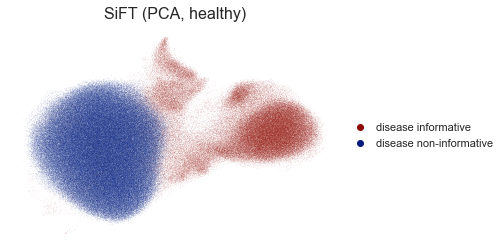

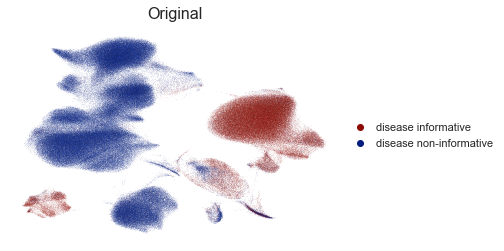

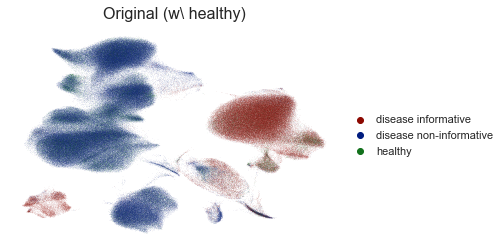

In [61]:
for key in adatas:
    for color in ["informative_cluster"]:
        sc.pl.umap(adatas[key], 
                   color=color,
                   frameon=False, 
                   show=False)
        
        plt.title(key, fontsize=16)
        # plt.savefig(FIG_DIR + f"{key}_{color}_umap.png", dpi=300, bbox_inches="tight", transparent=True)
        plt.show()

### IFN score

In [ ]:
adatas_sift = {}
adatas_sift["SiFT (disease informative)"] = adatas["SiFT (PCA, healthy)"][adatas["SiFT (PCA, healthy)"].obs["informative_cluster"] == "disease informative"].copy()
adatas_sift["SiFT (disease non-informative)"] = adatas["SiFT (PCA, healthy)"][adatas["SiFT (PCA, healthy)"].obs["informative_cluster"] == "disease non-informative"].copy()

In [ ]:
df_scores = sc.get.obs_df(adatas_sift["SiFT (disease informative)"], ["IFN_score_logfold",
                                                          "cell_type", 
                                                          "Status_on_day_collection_summary",
                                                         ]) 

df_scores = df_scores.rename(columns={"IFN_score_logfold":"IFN response (SiFT, disease informative)"})


df_scores_non = sc.get.obs_df(adatas_sift["SiFT (disease non-informative)"], ["IFN_score_logfold",
                                                          "cell_type", 
                                                          "Status_on_day_collection_summary",
                                                         ]) 

df_scores_non = df_scores_non.rename(columns={"IFN_score_logfold":"IFN response (SiFT, disease non-informative)"})

In [ ]:
dfs = {"SiFT (disease informative)": df_scores, 
       "SiFT (disease non-informative)": df_scores_non}

In [ ]:
dfs_grouped = {}
for key, df_ in dfs.items():
    dfs_grouped[key] = df_.groupby(["Status_on_day_collection_summary",  "cell_type",]).mean()
    

In [ ]:
dfs_full = {}
for key, dfs_grouped_ in dfs_grouped.items():
    dfs_ = {}
    columns = adatas_sift[key].obs["cell_type"].cat.categories
    index = adatas_sift[key].obs["Status_on_day_collection_summary"].cat.categories
    scores = dfs_grouped_.columns
    for score in scores:
        dfs_[score] = pd.DataFrame(columns=columns, index=index, dtype="float")
        for ind in dfs_grouped_.index:
            dfs_[score].loc[ind[0], ind[1]] =  float(dfs_grouped_.loc[ind, score])
        if "Healthy" in dfs_[score].index:
            dfs_[score] = dfs_[score].reindex(["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical",])
        else:
            dfs_[score] = dfs_[score].reindex(["Asymptomatic", "Mild", "Moderate", "Severe", "Critical",])
    dfs_full[key] = dfs_

In [ ]:
## Plot IFN response individual
rows = 1
cols = 1
size = 4
cmap = sns.color_palette("coolwarm", as_cmap=True)

for ki, keyi in enumerate(dfs_full):
    dfs_c = dfs_full[keyi]
    for kj, keyj in enumerate(dfs_full[keyi]):
        if "IFN response" in keyj:
            fig, axs = plt.subplots(rows, cols, figsize=(cols*(size*2), rows*size))
            mask = np.zeros_like(dfs_c[keyj])
            g = sns.heatmap(dfs_c[keyj], mask=mask,ax=axs, cmap=cmap)
            g.set_facecolor("grey")
            axs.set_title(keyj)
            axs.set_xticklabels(axs.get_xticklabels(), fontsize=16)
            axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)
            plt.tight_layout()
            plt.savefig(FIG_DIR + f"{keyj}.png", dpi=300, bbox_inches="tight", transparent=True)
            plt.show()


### Bar plot

In [62]:
full_orig_ct_counts =  pd.DataFrame(adatas["Original (w\\ healthy)"].obs["cell_type"].value_counts())
full_orig_ct_counts["type"] = "all"

healthy_ct_counts =  pd.DataFrame(adatas["Original (w\\ healthy)"][adatas["Original (w\\ healthy)"].obs["informative_cluster"] == "healthy"].obs["cell_type"].value_counts())
healthy_ct_counts["type"] = "healthy"
healthy_ct_counts["cell_type"] = healthy_ct_counts["cell_type"] / full_orig_ct_counts["cell_type"]
healthy_ct_counts = healthy_ct_counts.rename(columns={"cell_type": "cell_type_healthy"})

informative_ct_counts =  pd.DataFrame(adatas["Original (w\\ healthy)"][adatas["Original (w\\ healthy)"].obs["informative_cluster"] == "disease informative"].obs["cell_type"].value_counts())
informative_ct_counts["type"] = "disease informative"
informative_ct_counts["cell_type"] = informative_ct_counts["cell_type"] / full_orig_ct_counts["cell_type"]
informative_ct_counts = informative_ct_counts.rename(columns={"cell_type": "cell_type_informative"})

non_informative_ct_counts =  pd.DataFrame(adatas["Original (w\\ healthy)"][adatas["Original (w\\ healthy)"].obs["informative_cluster"] == "disease non-informative"].obs["cell_type"].value_counts())
non_informative_ct_counts["type"] = "disease non-informative"
non_informative_ct_counts["cell_type"] = (non_informative_ct_counts["cell_type"] / full_orig_ct_counts["cell_type"] ) + informative_ct_counts["cell_type_informative"]
non_informative_ct_counts = non_informative_ct_counts.rename(columns={"cell_type": "cell_type_non-informative"})


full_orig_ct_counts["cell_type"] = full_orig_ct_counts["cell_type"] / full_orig_ct_counts["cell_type"]


In [63]:
df_orig = pd.concat([healthy_ct_counts, non_informative_ct_counts, informative_ct_counts, full_orig_ct_counts], axis=1)
df_orig = df_orig.reset_index()
df_orig.sort_values(by="cell_type_healthy", inplace=True)
df_orig["index"] = df_orig["index"].cat.reorder_categories(df_orig["index"].values.to_numpy())

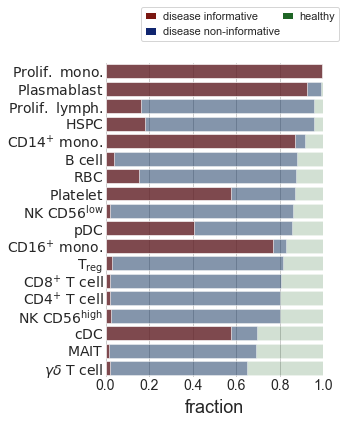

In [64]:
# Plot the total counts
f, ax = plt.subplots(figsize=(5, 6))
sns.set_color_codes("pastel")
sns.barplot(x="cell_type", y="index", data=df_orig,
            label="healthy", 
            color=informative_cluster_colors[-1],
            alpha = 0.2
           )

# Plot the crashes where alcohol was involved
sns.barplot(x="cell_type_non-informative", y="index", data=df_orig,
            label="disease non-informative", 
            color=informative_cluster_colors[1],
            alpha = 0.4)

sns.barplot(x="cell_type_informative", y="index", data=df_orig,
            label="disease informative", 
            color=informative_cluster_colors[0],
            alpha = 0.6)


# Add a legend and informative axis label
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2,1,0]

#add legend to plot
leg = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                ncol=2, 
                loc="lower right",
                bbox_to_anchor=(1.1, 1.05),
                columnspacing=.2,
                handlelength=1,
                handletextpad=0.6,
                frameon=True,)
for lh in leg.legendHandles:
    lh.set_alpha(1)

    
ax.set(xlim=(0, 1), ylabel="",
       xlabel="fraction",)
ax.set_xlabel("fraction", fontsize=18)

ticks_loc = ax.get_xticks().tolist()
ax.set_xticks(ticks_loc)
ax.set_xticklabels([f"{x:.1f}" for x in ticks_loc],  fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
sns.despine(left=True, bottom=True)

plt.tight_layout()
# plt.savefig(FIG_DIR + "disease_state_frac.png",  dpi=300, bbox_inches="tight", transparent=True)
plt.show()



In [65]:
adatas["SiFT (PCA, healthy)"].layers["X_noneg"] = adatas["SiFT (PCA, healthy)"].X.copy() -  adatas["SiFT (PCA, healthy)"].X.min()

In [66]:
## compare merged to non-merged cells
for key_, adata_ in adatas.items():
    adata_.uns["log1p"] = {'base': None}
    layer = "X_noneg" if key_ == 'SiFT (PCA, healthy)' else None
    sc.tl.rank_genes_groups(adata_, 
                            groupby="informative_cluster", 
                            method="wilcoxon",
                            layer=layer,
                            use_raw=False,
                            key_added="ind_clust_rank_genes_groups")


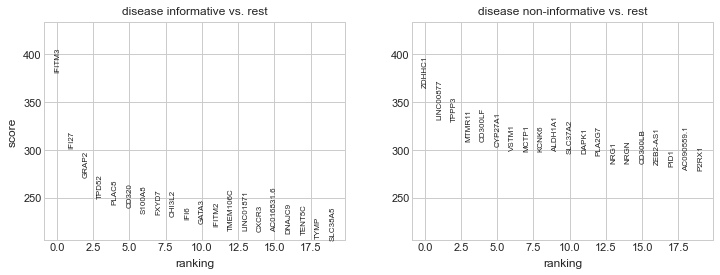

In [67]:
sc.pl.rank_genes_groups(adatas["SiFT (PCA, healthy)"], key="ind_clust_rank_genes_groups")

In [79]:
ind_genes = adatas["SiFT (PCA, healthy)"].uns["ind_clust_rank_genes_groups"]["names"]["disease informative"]
ind_genes[:50]

array(['IFITM3', 'IFI27', 'GRAP2', 'TPD52', 'PLAC8', 'CD320', 'S100A8',
       'FXYD7', 'CHI3L2', 'IFI6', 'GATA3', 'IFITM2', 'TMEM106C',
       'LINC01871', 'CXCR3', 'AC016831.6', 'DNAJC9', 'TENT5C', 'TYMP',
       'SLC38A5', 'SLC25A4', 'MAGED1', 'BOLA3', 'NCR3', 'CLU', 'S100A12',
       'TRAC', 'STMN1', 'IFITM1', 'CTSD', 'UNG', 'TIMP1', 'TIGIT',
       'TMEM156', 'S100A9', 'TIFA', 'MCM3', 'COL6A2', 'HOXB2', 'MT2A',
       'TMIGD2', 'CCND2', 'VAMP5', 'KLRC4', 'GRN', 'MATK', 'GBP1',
       'FCER1G', 'TRGV10', 'IGLV2-14'], dtype=object)

In [78]:
nonind_genes = adatas["SiFT (PCA, healthy)"].uns["ind_clust_rank_genes_groups"]["names"]["disease non-informative"]
nonind_genes[:50]

array(['ZDHHC1', 'LINC00877', 'TPPP3', 'MTMR11', 'CD300LF', 'CYP27A1',
       'VSTM1', 'MCTP1', 'KCNK6', 'ALDH1A1', 'SLC37A2', 'DAPK1', 'PLA2G7',
       'NRG1', 'NRGN', 'CD300LB', 'ZEB2-AS1', 'PID1', 'AC090559.1',
       'P2RX1', 'RGS18', 'UPK3A', 'ZFHX3', 'TBC1D8', 'FCAR', 'PTCH2',
       'IL1B', 'HCAR3', 'CSF2RB', 'MXD3', 'GAPT', 'SHTN1', 'CDK2AP1',
       'HNMT', 'CACNA2D3', 'GAS2L1', 'CSF1R', 'ENTPD1', 'IL13RA1',
       'AC007952.4', 'SOX4', 'P2RY13', 'SEMA4A', 'CSF2RA', 'CD93',
       'HDAC9', 'PTGIR', 'CEACAM4', 'CD1D', 'LPCAT2'], dtype=object)

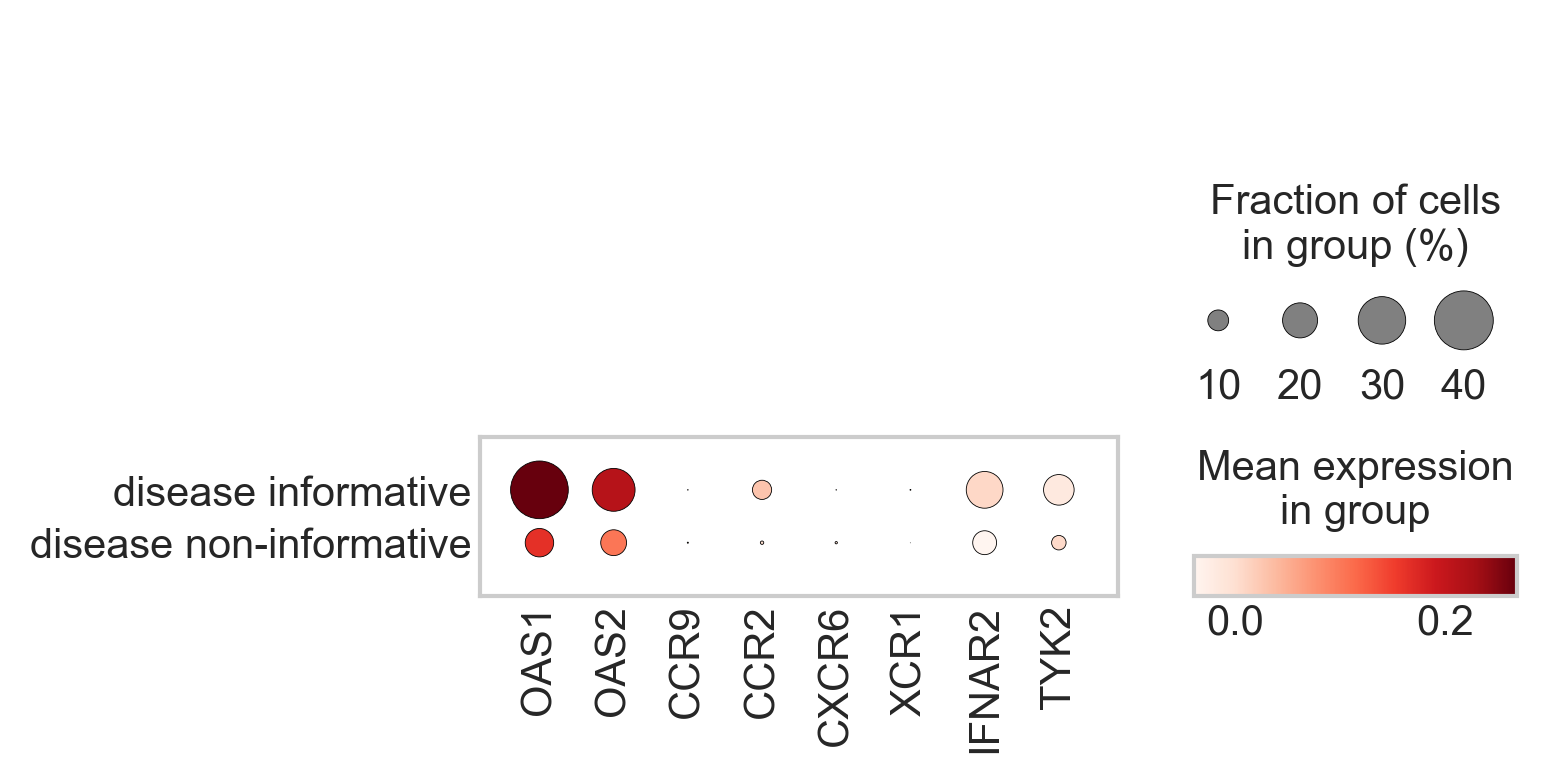

In [72]:
sc.pl.dotplot(
    adata=adatas['SiFT (PCA, healthy)'], 
    var_names=[ "OAS1", "OAS2", "CCR9","CCR2", "CXCR6", "XCR1", "IFNAR2","TYK2",], 
    groupby="informative_cluster",
    show=False
)

# plt.tight_layout()
# plt.savefig(FIG_DIR + f"SiFT (PCA, healthy)_GWAS.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

### [_clusterProfiler_](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html)

use the `R` _clusterProfiler_ package to find GO enrichment terms:
```{r}
genes = ind_genes[:50]

ego <- enrichGO(gene = genes, 
                OrgDb = "org.Hs.eg.db", 
                ont="BP", 
                keyType="SYMBOL",
                readable=FALSE)
ego2 <- simplify(ego)
pl = dotplot(ego2, showCategory=12,)
write.csv(pl$data, "./output/simplifiedgo_sift_informative.csv)
```

In [74]:
df_cp = pd.read_csv(DATA_DIR + "output/simplifiedgo_sift_informative.csv")
df_cp = df_cp.sort_values(by=['GeneRatio'], ascending=False)
df_cp["GO term"] = df_cp["Description"].copy()
GO_terms = []
for str_ in df_cp["GO term"]:
    list_ = re.findall(r"[\w']+", str_)
    if len(str_) > 40:
        idx_ = int(len(list_)/2-1)
        list_[idx_] = list_[idx_] + "\n" + list_[idx_+1]
        list_.pop(idx_+1)
        str_ = " ".join(list_)
    GO_terms.append(str_)

df_cp.iloc[:, -1] = GO_terms

In [75]:
df_cp[ "$-log_{10}(p_{adj})$"] = -1*np.log10(df_cp["p.adjust"])
df_cp["Gene fraction"] = df_cp["GeneRatio"]

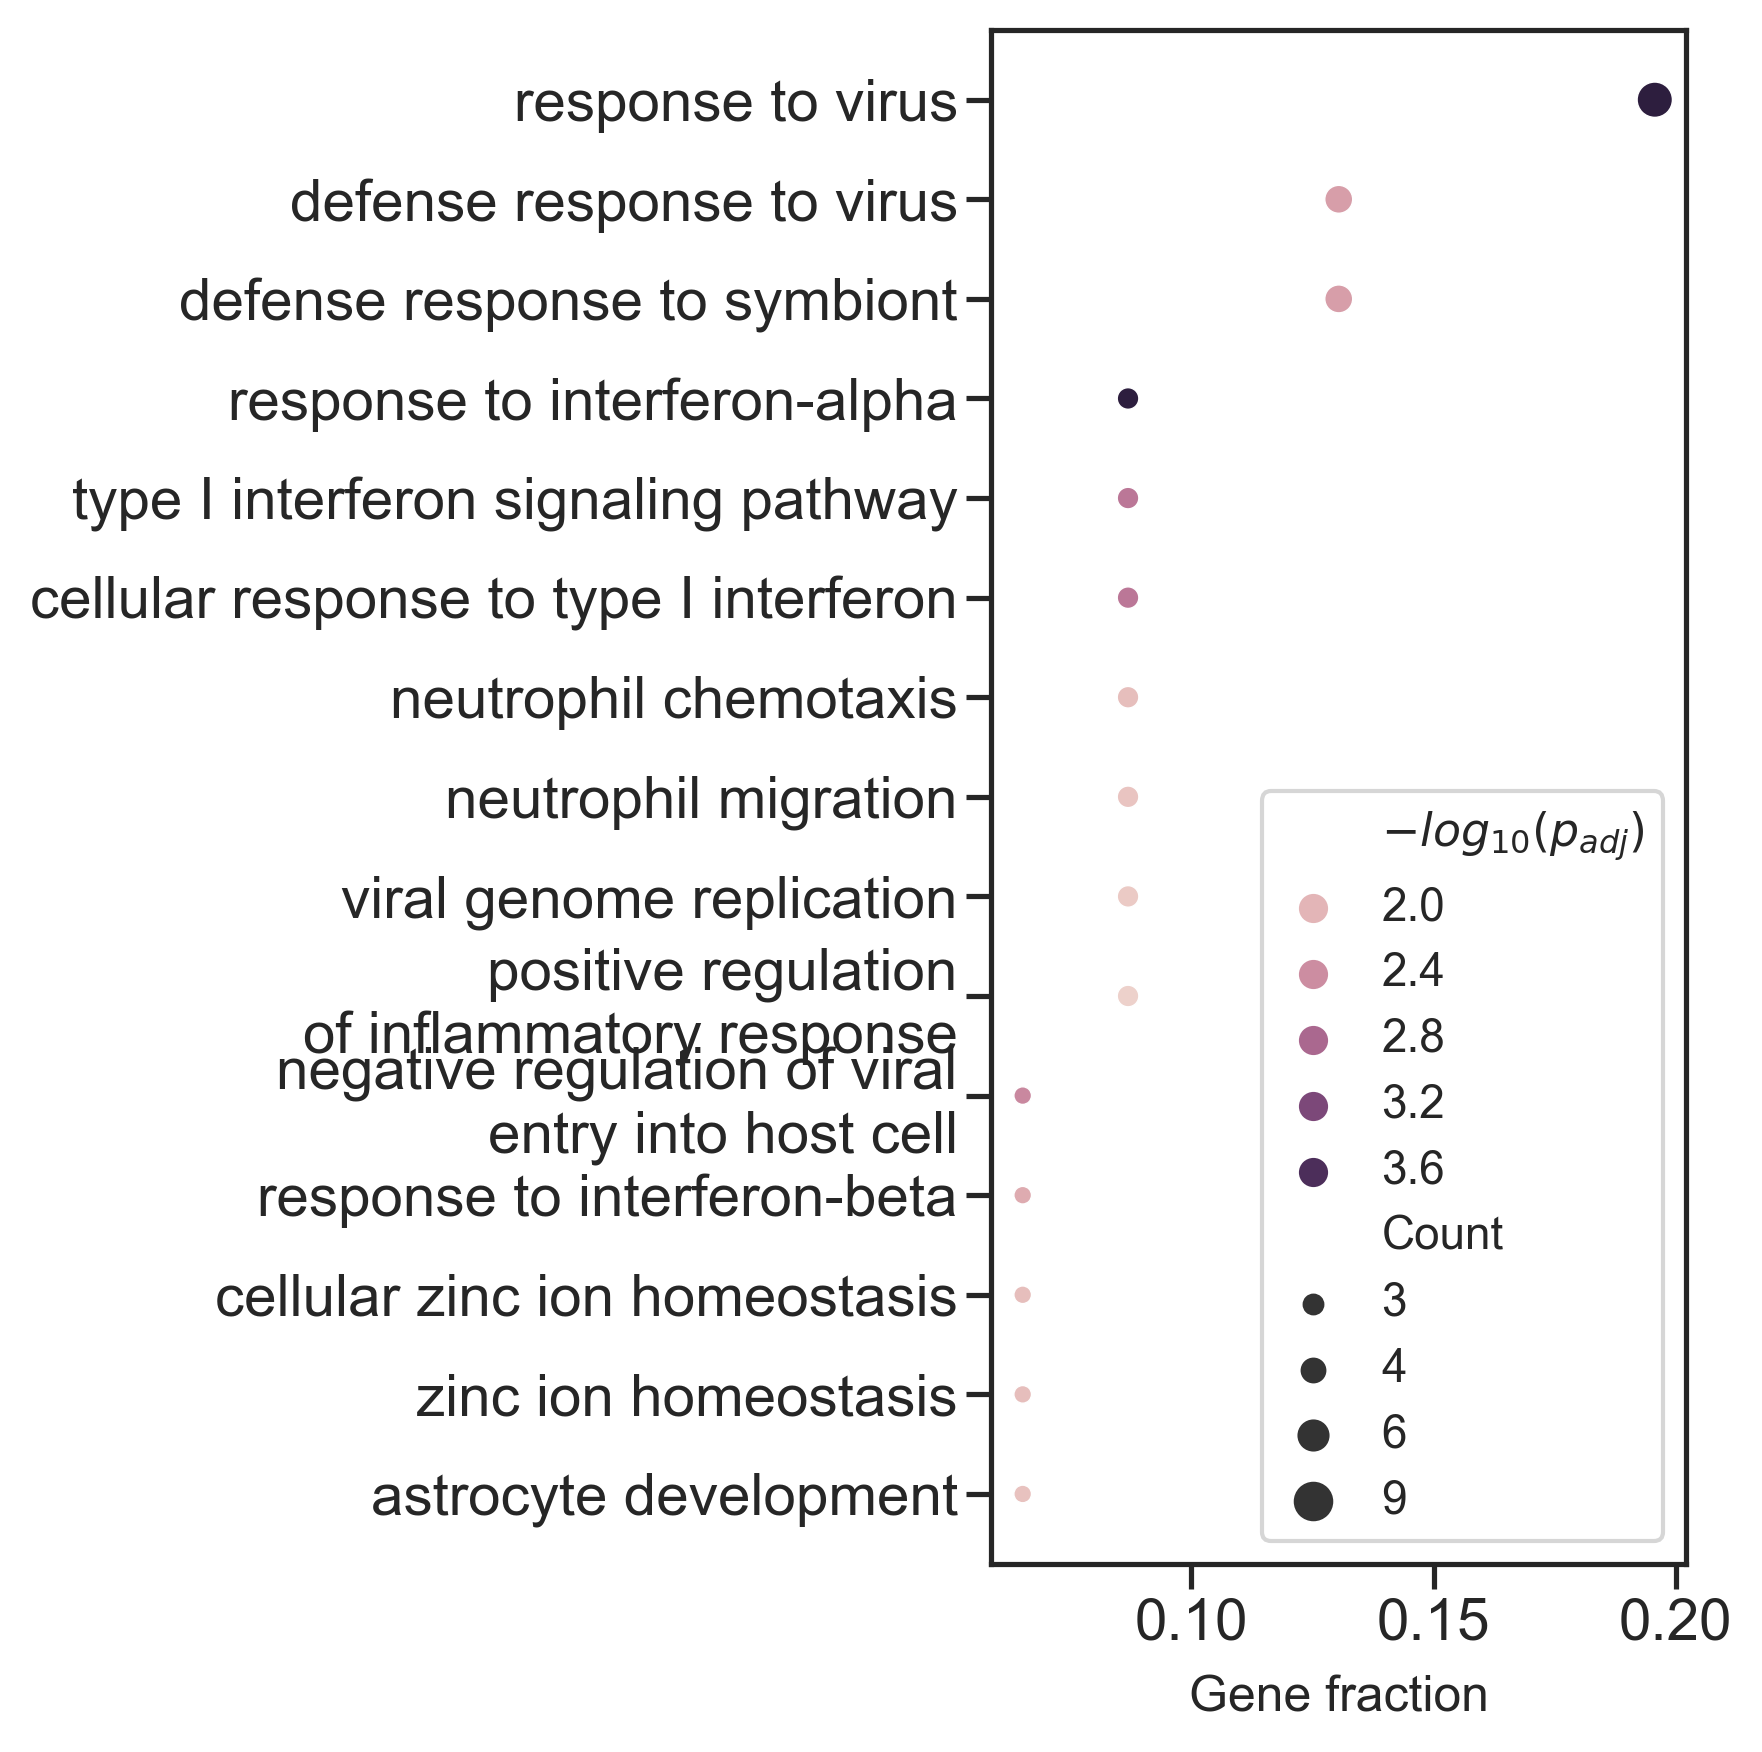

In [77]:
size = 6
fig, axs = plt.subplots(figsize=(size, size))
sns.set_theme(style="white")
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

sns.scatterplot(
    data=df_cp,
    x="Gene fraction", 
    y="GO term", 
    size="Count", 
    hue="$-log_{10}(p_{adj})$",
    ax=axs)

plt.legend(frameon=True)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
        
plt.tight_layout()
# plt.savefig(FIG_DIR + f"go_dots_sift_informative.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Save res

In [ ]:
adatas_paths_out = {'SiFT (PCA, healthy)': 'covid19.sift.knn.out.h5ad',
                    'Original': 'covid19.ref.out.h5ad',
                    'Original (w\\ healthy)': 'covid19.refh.out.h5ad'}

In [ ]:
for key_, path_ in adatas_paths_out.items():
    adatas[key_].write(DATA_DIR + path_)